In [ ]:
# to do:
# look at projection in each subspace
# Energy in each subspace

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto.plotting import *
from simplicial_kuramoto.chimera_measures import *

from simplicial_kuramoto.frustration_scan import *

In [16]:
def Null_Space_Plot(Gsc,graph,pos,savename=None):

    KerL1=sc.linalg.null_space(Gsc.L1.todense())

#     print(KerL1)
    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=pos, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=pos,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("bwr"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        if(savename):
            plt.savefig(savename+'_Ker_'+str(i)+'.pdf',format='pdf')
        plt.show()
        

In [241]:
G = nx.Graph()
list(G.nodes())


[]

In [251]:
def ring_of_rings(num_rings, ring_size, ring_gap=1):

    G = nx.Graph()
    for i in range(num_rings):
        gc = nx.generators.classic.circulant_graph(ring_size,[1])
        edges = gc.edges()
        
        if not list(G.nodes()):
            max_node_id = 0
        else:
            max_node_id = np.max(list(G.nodes()))

        for edge in edges:
            edge_ = tuple([(max_node_id) + x for x in edge])
            G.add_edge(edge_[0],edge_[1], community=i)
            
        for j in range(ring_gap):
            max_node_id = np.max(list(G.nodes()))
            G.add_edge(
                max_node_id, (max_node_id+1) % (num_rings * ring_size + num_rings*(ring_gap-1)), community=999,
            )
            
    return G

In [263]:

def simplicial_module_order_parameter(theta, community_assignment, harm_subspace, comms=None):

    Nc = len(np.unique(community_assignment))
    Nt = theta.shape[1]
    
    proj = np.zeros_like(theta.T)
    for direction in harm_subspace.T:
        proj += np.outer(theta.T.dot(direction), direction)
    proj[proj == 0] = 1

    if comms is None:
        comms = np.unique(community_assignment)

    order_parameters = np.zeros((Nc, Nt))
    for c in range(Nc):
        comm = np.unique(community_assignment)[c]
        if comm in comms:
            ind = np.argwhere(community_assignment == comm).reshape(-1)

            order_parameters[c] = np.absolute(np.exp(1j * theta[ind] / proj[:,ind].T).mean(axis=0))

    global_order_parameter = np.absolute(np.exp(1j * theta.T / proj).mean(axis=1))

    return order_parameters, global_order_parameter


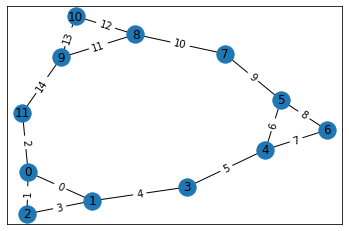

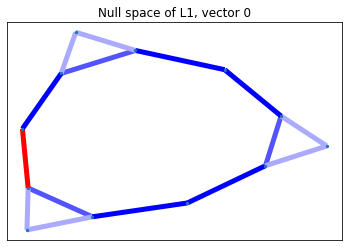

In [356]:
G = ring_of_rings(3, 3, 2)

edge_community_assignment = []
for node1, node2, data in G.edges.data():
    edge_community_assignment.append(data['community'])

Gsc = SimplicialComplex(graph=G, no_faces=False)

pos = nx.spring_layout(G,)
plt.figure()
nx.draw_networkx_nodes(G, pos=pos)
edge_labels = dict(((u, v), d) for d, (u, v) in enumerate(G.edges))                                                                                                                                                                                                                                         
node_labels = dict((u, d) for d, u in enumerate(G.nodes))                                                                                                                                                                                                                                                   
_=nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)  
_=nx.draw_networkx_labels(G, pos=pos, labels=node_labels)
_=nx.draw_networkx_edges(G,pos=pos)
plt.savefig('rotr_graph.png')

# plt.savefig(savename+'.pdf',format='pdf')

edge_community_assignment = []
for node1, node2, data in G.edges.data():
    edge_community_assignment.append(data['community'])

Null_Space_Plot(Gsc,G,pos,savename)

alpha_2= 0.0
alpha_2= 0.6981317007977318
alpha_2= 1.3962634015954636
alpha_2= 2.0943951023931953
alpha_2= 2.792526803190927
alpha_2= 3.490658503988659
alpha_2= 4.1887902047863905
alpha_2= 4.886921905584122
alpha_2= 5.585053606381854
alpha_2= 6.283185307179586


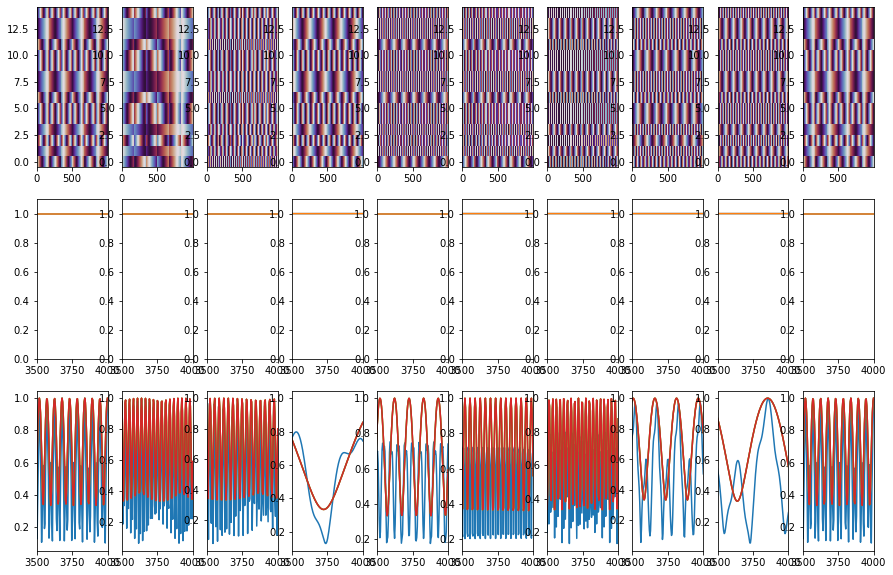

In [355]:
initial_phase = np.random.random(Gsc.n_edges)
grad_subspace, curl_subspace, harm_subspace = get_subspaces(Gsc)

# alpha1 = np.linspace(0,np.pi, 2)
alpha_1 = 1.0
alpha_2_val = np.linspace(0, 2*np.pi, 10)
n_repeats = 1
t_max = 4000
n_t = 1000
n_min = 0

#alpha_2_val=[0.0, 0.3, 0.45, 0.5, 0.7, 1.0, 1.4, 1.5]
# plt.figure(figsize=(4, 3))
fig, axs = plt.subplots(3,len(alpha_2_val),figsize=(15,10))

for i,alpha_2 in enumerate(alpha_2_val):
    print('alpha_2=', alpha_2)
    res = integrate_edge_kuramoto(
        Gsc,
        harm_subspace[:, 0],
        t_max,
        n_t,
        alpha_1=alpha_1 * harm_subspace[:, 0],
        alpha_2=alpha_2,
    )
    result = res.y[:, n_min:]
    time = res.t[n_min:]

    axs[0,i].imshow(mod(result),origin="lower",aspect="auto",cmap="twilight_shifted",interpolation="nearest")
    
    global_order, partial_orders = compute_simplicial_order_parameter(result, harm_subspace)
    axs[1,i].plot(time, global_order, label=f"alpha_2 = {alpha_2}")        
    axs[1,i].set_ylim([0, 1.1])
    for k in range(len(partial_orders)): 
        axs[1,i].plot(time, partial_orders[k], label=f"alpha_2 = {alpha_2}")
        axs[1,i].set_ylim([0, 1.1])
    axs[1,i].set_xlim([3500,4000])


    
    
    order_parameters, global_order_parameter = module_order_parameter(result, edge_community_assignment)
    axs[2,i].plot(time, global_order_parameter, label=f"alpha_2 = {alpha_2}")    
    for k in range(order_parameters.shape[0]-1):        
        axs[2,i].plot(time, order_parameters[k,:], label=f"alpha_2 = {alpha_2}")
        
    #axs[2,i].set_ylim([0, 1.1])
    axs[2,i].set_xlim([3500,4000])



plt.savefig('./rotr_alpha2scan.png')

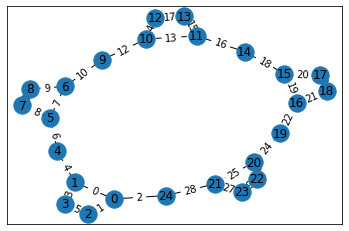

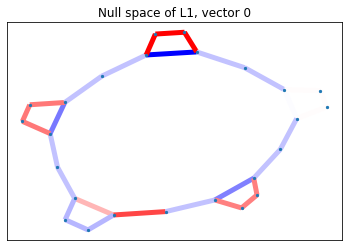

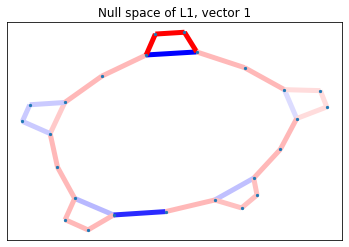

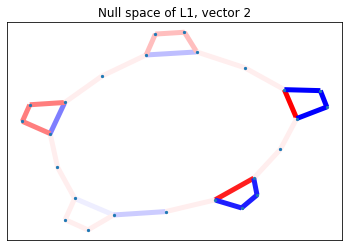

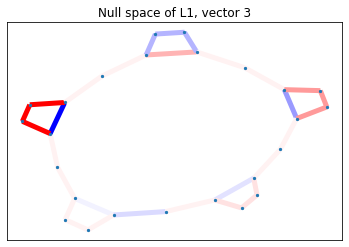

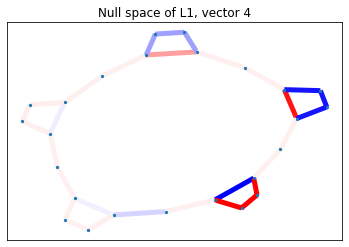

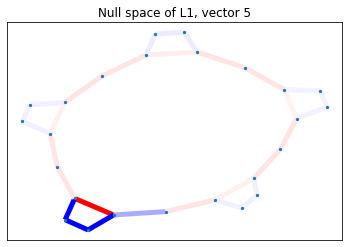

In [357]:
G = ring_of_rings(5, 4, 2)

edge_community_assignment = []
for node1, node2, data in G.edges.data():
    edge_community_assignment.append(data['community'])

Gsc = SimplicialComplex(graph=G, no_faces=False)

pos = nx.spring_layout(G,)
plt.figure()
nx.draw_networkx_nodes(G, pos=pos)
edge_labels = dict(((u, v), d) for d, (u, v) in enumerate(G.edges))                                                                                                                                                                                                                                         
node_labels = dict((u, d) for d, u in enumerate(G.nodes))                                                                                                                                                                                                                                                   
_=nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)  
_=nx.draw_networkx_labels(G, pos=pos, labels=node_labels)
_=nx.draw_networkx_edges(G,pos=pos)
plt.savefig('ror_graph.png')
# plt.savefig(savename+'.pdf',format='pdf')

edge_community_assignment = []
for node1, node2, data in G.edges.data():
    edge_community_assignment.append(data['community'])

Null_Space_Plot(Gsc,G,pos,savename)


alpha_2= 0


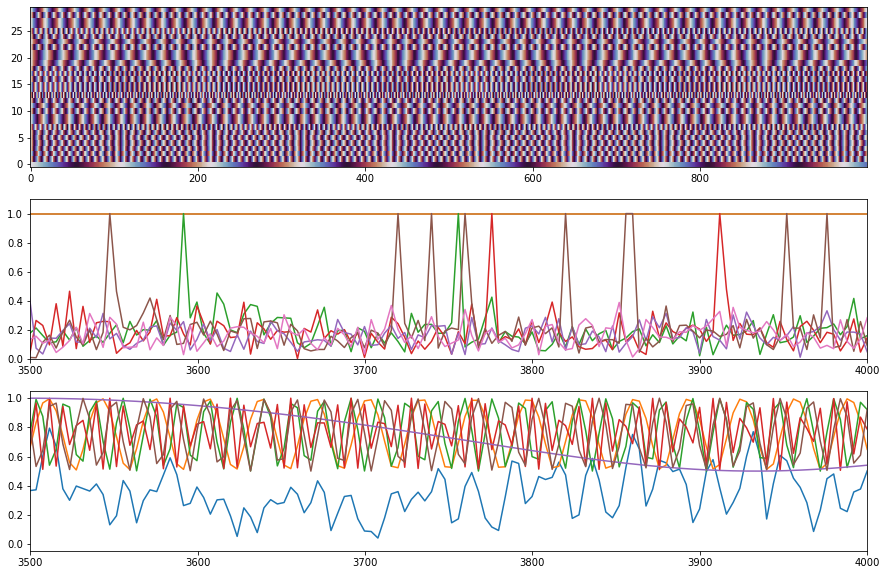

In [353]:
initial_phase = np.random.random(Gsc.n_edges)
grad_subspace, curl_subspace, harm_subspace = get_subspaces(Gsc)

# alpha1 = np.linspace(0,np.pi, 2)
alpha_1 = 1.0
alpha_2_val = np.linspace(0, 2*np.pi, 10)
n_repeats = 1
t_max = 4000
n_t = 1000
n_min = 0

#alpha_2_val=[0.0, 0.3, 0.45, 0.5, 0.7, 1.0, 1.4, 1.5]
# plt.figure(figsize=(4, 3))
fig, axs = plt.subplots(3,1,figsize=(15,10))

alpha_2 = 0

print('alpha_2=', alpha_2)
res = integrate_edge_kuramoto(
        Gsc,
        harm_subspace[:, 0],
        t_max,
        n_t,
        alpha_1=alpha_1 * harm_subspace[:, 0],
        alpha_2=alpha_2,
    )
result = res.y[:, n_min:]
time = res.t[n_min:]

axs[0].imshow(mod(result),origin="lower",aspect="auto",cmap="twilight_shifted",interpolation="nearest")
    
global_order, partial_orders = compute_simplicial_order_parameter(result, harm_subspace)
axs[1].plot(time, global_order, label=f"alpha_2 = {alpha_2}")        
axs[1].set_ylim([0, 1.1])
for k in range(len(partial_orders)): 
    axs[1].plot(time, partial_orders[k], label=f"alpha_2 = {alpha_2}")
    axs[1].set_ylim([0, 1.1])
axs[1].set_xlim([3500,4000])


    
    
order_parameters, global_order_parameter = module_order_parameter(result, edge_community_assignment)
axs[2].plot(time, global_order_parameter, label=f"alpha_2 = {alpha_2}")    
for k in range(order_parameters.shape[0]-1):        
    axs[2].plot(time, order_parameters[k,:], label=f"alpha_2 = {alpha_2}")
        
    #axs[2,i].set_ylim([0, 1.1])
axs[2].set_xlim([3500,4000])



plt.savefig('./ror.png')